In [1]:
import glob
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy
import re
import os
import pandas as pd
import pywt
from scipy.fftpack import fft
from warnings import warn
from sklearn import metrics

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# 对数据进行傅里叶变换
def apply_fft(x, fs, num_samples):
    f = np.linspace(0.0, (fs/2.0), num_samples//2)
    freq_values = fft(x)
    freq_values = 2.0/num_samples * np.abs(freq_values[0:num_samples//2])
    return f, freq_values


In [3]:
# 制作数据集及其特征标签
def make_dataset(data_src, num_samples, class_):
    files = glob.glob(data_src)
    files = np.sort(files)
    data = loadmat(files[0])
    keysList = sorted(data.keys())
    key = keysList[0]
    drive_end_data = data[key]
    drive_end_data = drive_end_data.reshape(-1)
    num_segments = np.floor(len(drive_end_data)/num_samples)
    slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
    silces = np.array(slices).reshape(int(num_segments), num_samples)
    # 初始化为第一个文件的分割数据
    segmented_data = silces
    # 处理剩余文件
    files = files[1:]
    for file in files:
        data = loadmat(file)
        keysList = sorted(data.keys())
        key = keysList[0]
        drive_end_data = data[key]
        drive_end_data = drive_end_data.reshape(-1)
        num_segments = np.floor(len(drive_end_data)/num_samples)
        # 等间隔取样
        slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
        # 并将结果重塑，重塑为nxnum_sample的矩阵
        silces = np.array(slices).reshape(int(num_segments), num_samples)
        segmented_data = np.concatenate( (segmented_data, silces) , axis=0, out=None)
    # 删除重复项
    segmented_data = np.unique(segmented_data, axis= 0) 
    #打乱数据
    np.random.shuffle( segmented_data) 
    # 创建类别标签
    Class_ = np.ones(len(segmented_data))*class_
    # 返回打乱的数据集和标签
    return segmented_data, Class_

In [4]:
#Healthy
#IR
#OR
#BF
#CompF
#*IR = Inner Race fault
#*OR = Outer Race faults
#*BF = Ball faults
#*CompF = Combination of faults
 
# 加载数据集，一个样本分成50个数据集，一共是12 x 50 = 600 
 
num_samples = 40000 # 输入长度
fs = 200000; # 采样频率
data_path = (r"D:\WorkSpace\研一\现代信号处理\wotaihua_data") 
 
cls_1 = '1-a healthy bearing/*'
cls_2 = '2-a bearing with inner race fault/*'
cls_3 = '3-a bearing with outer race fault/*'
cls_4 = '4-a bearing with ball fault/*'
cls_5 = '5-a bearing with a combination of faults/*'

In [5]:
norm, y_norm   = make_dataset(os.path.join(data_path, cls_1), num_samples, 0)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_2), num_samples, 1)
defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_3), num_samples, 2)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_4), num_samples, 3)
defc4, y_defc4 = make_dataset(os.path.join(data_path, cls_5), num_samples, 4)
# 分别加载X，y，并沿着轴的方向连接
X = np.concatenate( (norm, defc1, defc2, defc3, defc4) , axis=0, out=None)
Y = np.concatenate( (y_norm, y_defc1, y_defc2, y_defc3, y_defc4), axis=0, out=None)

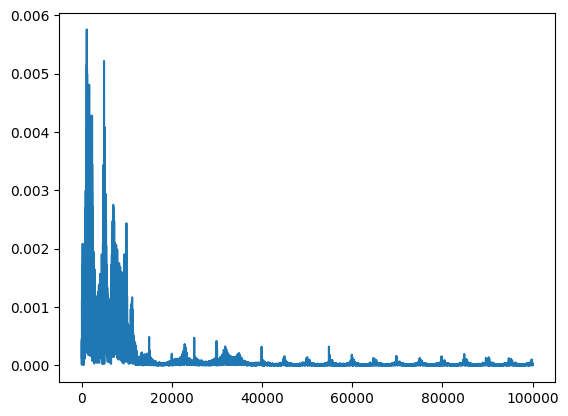

In [26]:
# 进行小波包分解和特征提取
wavelet_function = "db4" #db4小波
num_levels = 7 # 分解层数
m = 5  #m个最高幅度及其对应的频率
 
#小波包分解和特征提取，特征的数目2**7个 128个特征
num_features = 2**num_levels
# 存储特征的数组，创建一个 600x5行，5x128列的特征集合
features = np.repeat(np.nan, len(X)*m*num_features).reshape(len(X),m*num_features)
# 对单独一个样本进行小波分解，并遍历每一个样本
for i in range(len(X)):    
    wp = pywt.WaveletPacket(X[i], wavelet = wavelet_function, maxlevel = num_levels) # 小波包分解
    # 获取小波包分解后每个子频带的路径名->list 7
    # rewp=wp.reconstruct(update=False)
    # f, c = apply_fft(rewp, fs, len(rewp))
    # z = abs(c)
    # plt.plot(f,z)
    # plt.savefig(r'复合.png',dpi=180)
    # plt.show()
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    # 遍历每个子频带
    for j in range(num_features):
        # 创建一个新的小波子频带对象，并赋值
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        #从小波包系数重建信号，并进行傅里叶变换，返回频谱频率和频谱幅度
        reconstructed_signal = new_wp.reconstruct(update = False) #从小波包系数重建信号
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        # plt.plot(f,z)
        # plt.show()
        #求频谱的m个最高幅度及其对应的频率 -m表示从末尾往前数m个元素
        maximal_idx = np.argpartition(z, -m)[-m:]
        # 找到最大的幅值--list
        high_amp = z[maximal_idx]
        # 找到对应的频率--list
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq #length=5
        
        l = 0
        for f in feature:
            features[i,j*m+l] = f
            l = l+1
    #     break
    # break

        
        

    


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, f1_score, classification_report

In [14]:
labels = pd.Categorical(Y)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, 
                                                    shuffle = True, stratify = labels)#random_state = 42

In [16]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(X_train)
test_data_scaled = scaler.transform(X_test)


In [17]:
clf_RF = RandomForestClassifier(criterion='entropy', max_features = 1, min_samples_leaf=1, min_samples_split=3, 
                                max_depth=20, n_estimators=200)
clf_RF.fit(train_data_scaled, y_train)


RandomForestClassifier(criterion='entropy', max_depth=20, max_features=1,
                       min_samples_split=3, n_estimators=200)

Confusion Matrix:
[[120   0   0   0   0]
 [  0 115   0   1   4]
 [  0   0 120   0   0]
 [  0   0   0 120   0]
 [  0   0   0   0 120]]
Accuracy: 0.9916666666666667
Precision: 0.9918954945347908
Recall: 0.9916666666666668
F1 Score: 0.9916361168078014


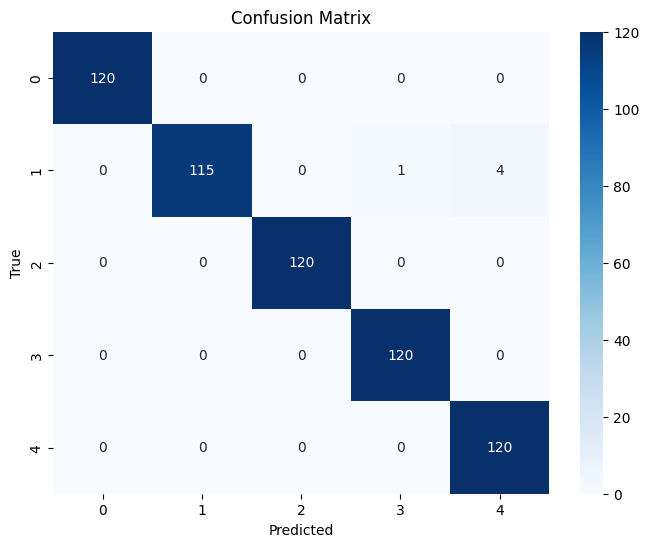

In [19]:
y_pred = clf_RF.predict(test_data_scaled)

# 生成混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 计算和显示精度、召回率、F1分数等
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('混淆矩阵.png',dpi=180)
plt.show()
